In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

## データの読み込み

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
display(df_train.head())
display(df_test.head())

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


,datetime,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-10-1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1


## trainとtestは結合して処理する
- メニューやイベントにおいてどちらかにないというのにフラグがたてられないため

In [4]:
df_train.loc[:, "data_flg"] = 1
df_test.loc[:, "data_flg"] = 0
df_test.loc[:, "y"] = np.nan
df_test = df_test[df_train.columns]

In [5]:
dataset_df = pd.concat([df_train, df_test])

## 時間の処理をしておく

In [6]:
dataset_df["datetime"] = pd.to_datetime(dataset_df["datetime"])

## カテゴリ化する

In [7]:
def make_dummies(df_c):
    source = df_c.copy()
    dummy_df = pd.DataFrame([])
    dummy_col = ["week", "remarks", "event"]
    for col in dummy_col:
        dummy = pd.get_dummies(df_c[col])
        dummy_df = pd.concat([dummy_df, dummy], axis=1)
    source = source.drop(dummy_col, axis = 1)
    
    return pd.concat([source, dummy_df], axis=1)

In [8]:
dataset_df = make_dummies(dataset_df)

## 天気を数値へ変換する
|天気コード|天気|
|-------|----|
|快晴|1|
|晴れ|2|
|薄曇|3|
|曇  |4|
|雨  |5|
|雪  |6|
|雷電 |7|

In [9]:
weather_dict = {"快晴":1, "晴れ":2, "薄曇":3, "曇":4, "雨":5, "雪":6, "雷電":7}

In [10]:
dataset_df["weather"] = dataset_df["weather"].map(lambda x: weather_dict[x])

## 降水量の置換

In [11]:
dataset_df["precipitation"] = dataset_df["precipitation"].map(lambda x: 0 if x=="--" else x)

In [12]:
dataset_df.to_csv("dataset_df.csv", index=False)

## 給料日の経過日数

In [13]:
pay_df = pd.read_csv("給料日日付データ.csv")

In [14]:
pay_df["datetime"] = pd.to_datetime(pay_df["datetime"])
pay_df["経過終了日"] = pay_df["datetime"]
pay_df = pay_df.set_index("datetime")
pay_day = pay_df[pay_df["給料日"] == 1]
pay_day["経過開始日"] = pay_day["経過終了日"].shift()
pay_day["経過終了日"] = pay_day["経過終了日"] - timedelta(days=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
keika_df = pd.DataFrame([])
for d in pay_day[["経過開始日", "経過終了日"]].values:
    temp = pay_df[d[0]: d[1]].reset_index(drop=False).reset_index(drop=False)
    temp = temp[["datetime","index"]]
    keika_df = pd.concat([keika_df, temp])
keika_df = keika_df.rename(columns={"index": "給料日経過日数"})
keika_df["給料日経過日数"] = keika_df.loc[:, "給料日経過日数"] + 1

In [16]:
keika_df.head()

,datetime,給料日経過日数
0,2013-11-08,1
1,2013-11-09,2
2,2013-11-10,3
3,2013-11-11,4
4,2013-11-12,5


In [17]:
dataset_df = pd.merge(dataset_df, keika_df, how="left", on="datetime")
dataset_df = dataset_df.drop("payday", axis=1)

## kcalの欠損を埋める

In [18]:
menu_df = pd.read_csv("メニュー分類.csv")
menu_columns = list(menu_df.columns)
menu_ = list(menu_df.columns)
menu_.remove("name")
menu_columns.append("kcal")

In [19]:
#おいちゃん特性のメニュー分類の結合
dataset_df = pd.merge(dataset_df, menu_df, how="left", on="name")

In [20]:
# 欠損と欠損じゃないのを分ける
no_missing_tf = dataset_df["kcal"] == dataset_df["kcal"]
no_missing_data = dataset_df[no_missing_tf]
missing_data = dataset_df[~no_missing_tf]
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 45


#### 欠損を除外してkcalの平均を算出
#### 重複メニューにkcalが入っていた場合はそれを使う

In [21]:
equal_name_kcal_dict = pd.DataFrame(no_missing_data.groupby("name").mean()["kcal"]).to_dict()

In [22]:
for i in equal_name_kcal_dict["kcal"].keys():
    missing_data.loc[missing_data["name"] == i, "kcal"] = equal_name_kcal_dict["kcal"][i]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 33


#### その他はおいちゃん特性のメニュー分類で埋める

In [24]:
for i in menu_:
    equal_menu_mean = no_missing_data[no_missing_data[i] == 1]["kcal"].mean()
    print ("メニュー：{0} {1}".format(i, equal_menu_mean))
    missing_data.loc[(missing_data[i] == 1) & (missing_data["kcal"].isnull()), "kcal"] = equal_menu_mean

メニュー：カツ 411.10714285714283
メニュー：カレー 410.0
メニュー：ハンバーグ 408.8333333333333
メニュー：中華 405.0408163265306
メニュー：フライ 422.0
メニュー：チキン 408.1666666666667
メニュー：その他 406.0813953488372


In [25]:
print ("欠損メニュー数：",missing_data["kcal"].isnull().sum())

欠損メニュー数： 0


In [26]:
con_dataset = pd.concat([no_missing_data, missing_data])

### 9週間前の同曜日の値を入れる

In [27]:
con_dataset = con_dataset.sort_values("datetime")

In [28]:
con_dataset['day_of_the_week'] = con_dataset["datetime"].map(lambda x: x.weekday_name)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


In [29]:
fin_dataset = pd.DataFrame([])
for i, d in con_dataset.groupby("day_of_the_week"):
    sift = list(d["y"].shift(9).reset_index(drop=True))
    d = d.reset_index(drop=True)
    d.loc[:, "y_shift_youbi"] = sift
    fin_dataset = pd.concat([fin_dataset, d])
fin_dataset = fin_dataset.sort_values("datetime").reset_index(drop=True)

In [30]:
fin_dataset.tail()

,datetime,y,soldout,name,kcal,weather,precipitation,temperature,data_flg,月,...,給料日経過日数,カツ,カレー,ハンバーグ,中華,フライ,チキン,その他,day_of_the_week,y_shift_youbi
242,2014-11-21,NaN,0,ロコモコ丼,406.081395,1,0,14.9,0,0,...,12,0,0,0,0,0,0,1,Friday,45.0
243,2014-11-25,NaN,1,なすと挽肉のはさみ揚げ,460.000000,5,1.5,11.4,0,0,...,16,0,0,0,0,0,0,1,Tuesday,56.0
244,2014-11-26,NaN,1,鶏肉の治部煮風,415.000000,5,1,9.2,0,0,...,17,0,0,0,0,0,0,1,Wednesday,59.0
245,2014-11-27,NaN,0,牛丼風,420.000000,1,0,15.1,0,0,...,18,0,0,0,0,0,0,1,Thursday,50.0
246,2014-11-28,NaN,0,鶏肉のスイートチリソース,416.000000,4,0,15.3,0,0,...,19,0,0,0,0,0,0,1,Friday,45.0


In [31]:
fin_dataset.to_csv("dataset_df.csv", index=False)

## カレンダーデータの作成

In [32]:
import jpholiday
import datetime

In [33]:
jp_calendar_data = pd.DataFrame(index=pd.date_range(start='2013-11-4', end='2014-12-15', freq='1D'))

In [34]:
jp_calendar_data.index

DatetimeIndex(['2013-11-04', '2013-11-05', '2013-11-06', '2013-11-07',
               '2013-11-08', '2013-11-09', '2013-11-10', '2013-11-11',
               '2013-11-12', '2013-11-13',
               ...
               '2014-12-06', '2014-12-07', '2014-12-08', '2014-12-09',
               '2014-12-10', '2014-12-11', '2014-12-12', '2014-12-13',
               '2014-12-14', '2014-12-15'],
              dtype='datetime64[ns]', length=407, freq='D')

曜日

In [35]:
jp_calendar_data['day_of_the_week'] = jp_calendar_data.index.map(lambda x: x.weekday_name)

休日フラグ

In [36]:
jp_calendar_data['holiday_flg'] = jp_calendar_data.index.map(lambda x: 1 if jp_calendar_data['day_of_the_week'][x] in ['Saturday', 'Sunday']  or jpholiday.is_holiday(x) else 0)

休日名

In [37]:
jp_calendar_data['holiday_name'] = jp_calendar_data.index.map(lambda x: jpholiday.is_holiday_name(x))

休日からの経過日数

In [38]:
jp_calendar_data['days_from_last_holiday'] = pd.Series()
passed_days = 0
for idx in jp_calendar_data.index:
    if jp_calendar_data['holiday_flg'][idx]:
        passed_days = 0
    jp_calendar_data['days_from_last_holiday'][idx] = passed_days
    passed_days += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
jp_calendar_data['days_of_consecutive_holidays'] = pd.Series()
passed_days = 0
for idx in jp_calendar_data.index:
    if jp_calendar_data['holiday_flg'][idx]:
        passed_days += 1
        jp_calendar_data['days_of_consecutive_holidays'][idx] = passed_days
    else:
        passed_days = 0
        jp_calendar_data['days_of_consecutive_holidays'][idx] = passed_days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [40]:
jp_calendar_data.head()

,day_of_the_week,holiday_flg,holiday_name,days_from_last_holiday,days_of_consecutive_holidays
2013-11-04,Monday,1,文化の日 振替休日,0.0,1.0
2013-11-05,Tuesday,0,None,1.0,0.0
2013-11-06,Wednesday,0,None,2.0,0.0
2013-11-07,Thursday,0,None,3.0,0.0
2013-11-08,Friday,0,None,4.0,0.0


### 後処理

In [41]:
fin_train_data = fin_dataset[fin_dataset["data_flg"] == 1].reset_index(drop=True)
fin_train_data = fin_train_data.drop(["name", "data_flg"], axis=1)
fin_test_data = fin_dataset[fin_dataset["data_flg"] == 0].reset_index(drop=True)
fin_test_data = fin_test_data.drop(["name", "data_flg", "y"], axis=1)

In [42]:
fin_train_data = fin_train_data[  (fin_train_data["datetime"] >= "2014-02-12") 
                                & (fin_train_data["datetime"] <= fin_train_data["datetime"].max())
                               ]

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_data, val_data = train_test_split(fin_train_data, test_size=0.2, shuffle=False)

In [45]:
print (train_data.shape)
print (val_data.shape)
print (fin_test_data.shape)

(124, 31)
(31, 31)
(40, 30)


In [46]:
train_data.to_csv("output_train_data.csv", index=False)
val_data.to_csv("output_val_data.csv", index=False)
fin_test_data.to_csv("output_test_data.csv", index=False)

csvに保存

In [47]:
jp_calendar_data.to_csv("./jp_calendar_data.csv")

# 予測

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas_profiling as pdp
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.core.display import display, HTML

### データの読み込み

In [49]:
train_data = pd.read_csv("./output_train_data.csv")
val_data = pd.read_csv("./output_val_data.csv")
test_data = pd.read_csv("./output_test_data.csv")

train_data = train_data.set_index('datetime').sort_index()
val_data = val_data.set_index('datetime').sort_index()
test_data = test_data.set_index('datetime').sort_index()

In [50]:
jp_calendar_data = pd.read_csv("./jp_calendar_data.csv", index_col=0)
jp_calendar_data.index = pd.to_datetime(jp_calendar_data.index)

時間をインデックスにする

In [51]:
jp_calendar_data = jp_calendar_data.drop(['day_of_the_week', 'holiday_name'], axis=1)

In [52]:
jp_calendar_data.head()

,holiday_flg,days_from_last_holiday,days_of_consecutive_holidays
2013-11-04,1,0.0,1.0
2013-11-05,0,1.0,0.0
2013-11-06,0,2.0,0.0
2013-11-07,0,3.0,0.0
2013-11-08,0,4.0,0.0


### カレンダーデータをマージする

In [53]:
train_data_merged = pd.merge(train_data, jp_calendar_data, left_index=True, right_index=True)
val_data_merged = pd.merge(val_data, jp_calendar_data, left_index=True, right_index=True)
test_data_merged = pd.merge(test_data, jp_calendar_data, left_index=True, right_index=True)

In [54]:
train_data_merged.to_csv("train_data_merged.csv")
val_data_merged.to_csv("val_data_merged.csv")
test_data_merged.to_csv("test_data_merged.csv")

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### 説明変数と目的変数を分離する。

In [56]:
features = train_data_merged.columns[train_data_merged.columns!='y'] # 説明変数
features

Index(['soldout', 'kcal', 'weather', 'precipitation', 'temperature', '月', '木',
       '水', '火', '金', 'お楽しみメニュー', 'スペシャルメニュー（800円）', '手作りの味', '料理長のこだわりメニュー',
       '近隣に飲食店複合ビルオープン', '酢豚（28食）、カレー（85食）', '鶏のレモンペッパー焼（50食）、カレー（42食）',
       'キャリアアップ支援セミナー', 'ママの会', '給料日経過日数', 'カツ', 'カレー', 'ハンバーグ', '中華', 'フライ',
       'チキン', 'その他', 'day_of_the_week', 'y_shift_youbi', 'holiday_flg',
       'days_from_last_holiday', 'days_of_consecutive_holidays'],
      dtype='object')

In [57]:
features = ["soldout", "kcal", #ご飯の情報
            "weather", "precipitation", "temperature", # 天気
            "月","火", "水", "木", "days_from_last_holiday", # カレンダー
            "お楽しみメニュー", "キャリアアップ支援セミナー", "ママの会", "給料日経過日数", #イベント
            "カツ", "カレー", "ハンバーグ", "中華", "フライ", #メニュー
            "y_shift_youbi" # 自己回帰
           ]

In [58]:
X_train_data = train_data_merged[features]
y_train_data = train_data_merged['y'].copy()

In [59]:
X_val_data = val_data_merged[features]
y_val_data = val_data_merged['y'].copy()

In [60]:
X_val_data.head()

,soldout,kcal,weather,precipitation,temperature,月,火,水,木,days_from_last_holiday,お楽しみメニュー,キャリアアップ支援セミナー,ママの会,給料日経過日数,カツ,カレー,ハンバーグ,中華,フライ,y_shift_youbi
2014-08-12,1,400.0,5,0,29.4,0,1,0,0,2.0,0,0,0,5,1,0,0,0,0,56.0
2014-08-18,0,396.0,4,0,32.2,1,0,0,0,1.0,0,0,0,11,1,0,0,0,0,74.0
2014-08-19,1,385.0,2,0,33.3,0,1,0,0,2.0,0,0,0,12,0,0,0,0,0,63.0
2014-08-20,0,423.0,1,0,33.3,0,0,1,0,3.0,0,0,1,13,0,0,0,0,0,50.0
2014-08-21,0,405.0,3,0,33.0,0,0,0,1,4.0,0,1,0,14,0,0,0,1,0,72.0


説明変数を標準化する

In [61]:
scaler = StandardScaler()
scaler.fit(X_train_data)
X_train_data_scaled = pd.DataFrame(scaler.transform(X_train_data), columns=X_train_data.columns)
X_val_data_scaled = pd.DataFrame(scaler.transform(X_val_data), columns=X_val_data.columns)

In [62]:
X_train_data_scaled.head()

,soldout,kcal,weather,precipitation,temperature,月,火,水,木,days_from_last_holiday,お楽しみメニュー,キャリアアップ支援セミナー,ママの会,給料日経過日数,カツ,カレー,ハンバーグ,中華,フライ,y_shift_youbi
0,-0.892805,0.524520,0.752191,-0.215801,-1.830186,-0.489898,-0.477203,1.941451,-0.515079,-1.331661,-0.296174,-0.157459,-0.20498,-1.386867,-0.356753,-0.312002,-0.279751,-0.540062,-0.204980,1.705115
1,-0.892805,1.305767,0.752191,-0.215801,-1.817705,-0.489898,-0.477203,-0.515079,1.941451,-0.616830,-0.296174,-0.157459,-0.20498,-1.272903,-0.356753,-0.312002,-0.279751,1.851640,-0.204980,2.372521
2,1.120065,1.101963,2.176185,0.378850,-2.466755,-0.489898,-0.477203,-0.515079,-0.515079,0.098001,-0.296174,-0.157459,-0.20498,-1.158939,-0.356753,-0.312002,-0.279751,-0.540062,-0.204980,0.537154
3,1.120065,0.558487,-0.671804,-0.215801,-1.168654,2.041241,-0.477203,-0.515079,-0.515079,-1.331661,-0.296174,-0.157459,-0.20498,-0.817048,-0.356753,-0.312002,-0.279751,1.851640,-0.204980,-0.330474
4,-0.892805,0.898160,-0.671804,-0.215801,-1.767778,-0.489898,2.095544,-0.515079,-0.515079,-0.616830,-0.296174,-0.157459,-0.20498,-0.703084,2.803060,-0.312002,-0.279751,-0.540062,4.878524,1.771856


## 線形回帰

学習モデルの作成

In [63]:
lr = LinearRegression().fit(X_train_data_scaled, y_train_data)

予測値の算出

In [64]:
y_pred_train_data_lr = lr.predict(X_train_data_scaled)
y_pred_val_data_lr = lr.predict(X_val_data_scaled)

In [65]:
print("学習データの決定係数：{}".format(lr.score(X_train_data_scaled, y_train_data)))
print("テストデータの決定係数：{}".format(lr.score(X_val_data_scaled, y_val_data)))
print("モデルの説明変数の係数：{}".format(lr.coef_))
print("モデルのy切片：{}".format(lr.intercept_))

学習データの決定係数：0.7191878634312043
テストデータの決定係数：0.35056561139145204
モデルの説明変数の係数：[  1.43364393   1.83634397  -2.38985044   2.82672543 -12.3468896
   9.43128089   5.27726778   4.07043114   2.62821021  -0.0708132
  12.5234926    1.0082204    0.38991074   0.63517535   2.3140712
   5.02441912   2.46787178   0.45548774  -1.78611033   3.41760274]
モデルのy切片：77.58870967741936


In [66]:
stem_df = pd.DataFrame({"features":features})
stem_df["coef"] = lr.coef_
# stem_df

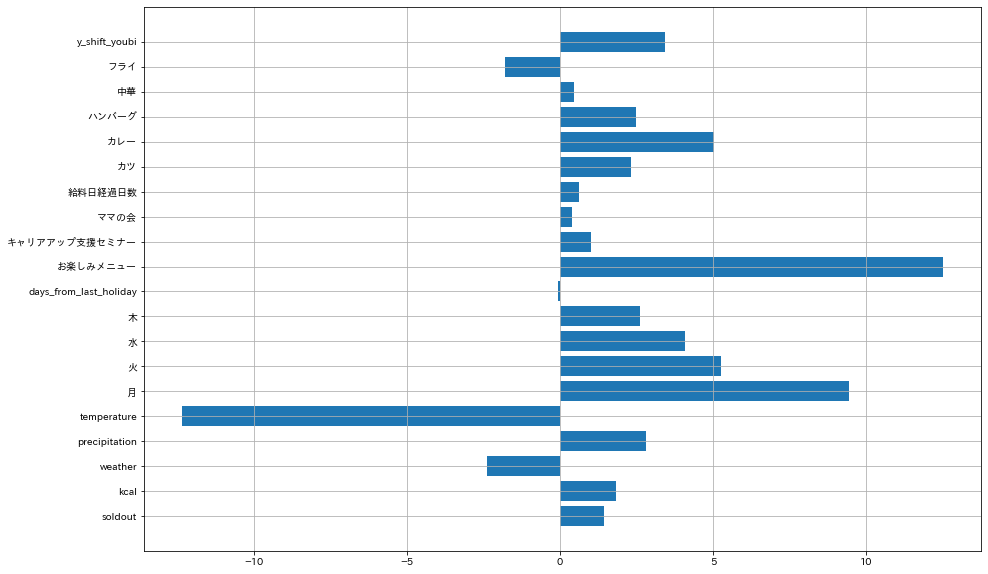

In [67]:
plt.subplots(figsize=(15,10))
x = stem_df.features
y = stem_df.coef

x_position = np.arange(len(x))
plt.barh(x_position, y, tick_label=x)
plt.grid()
plt.show()

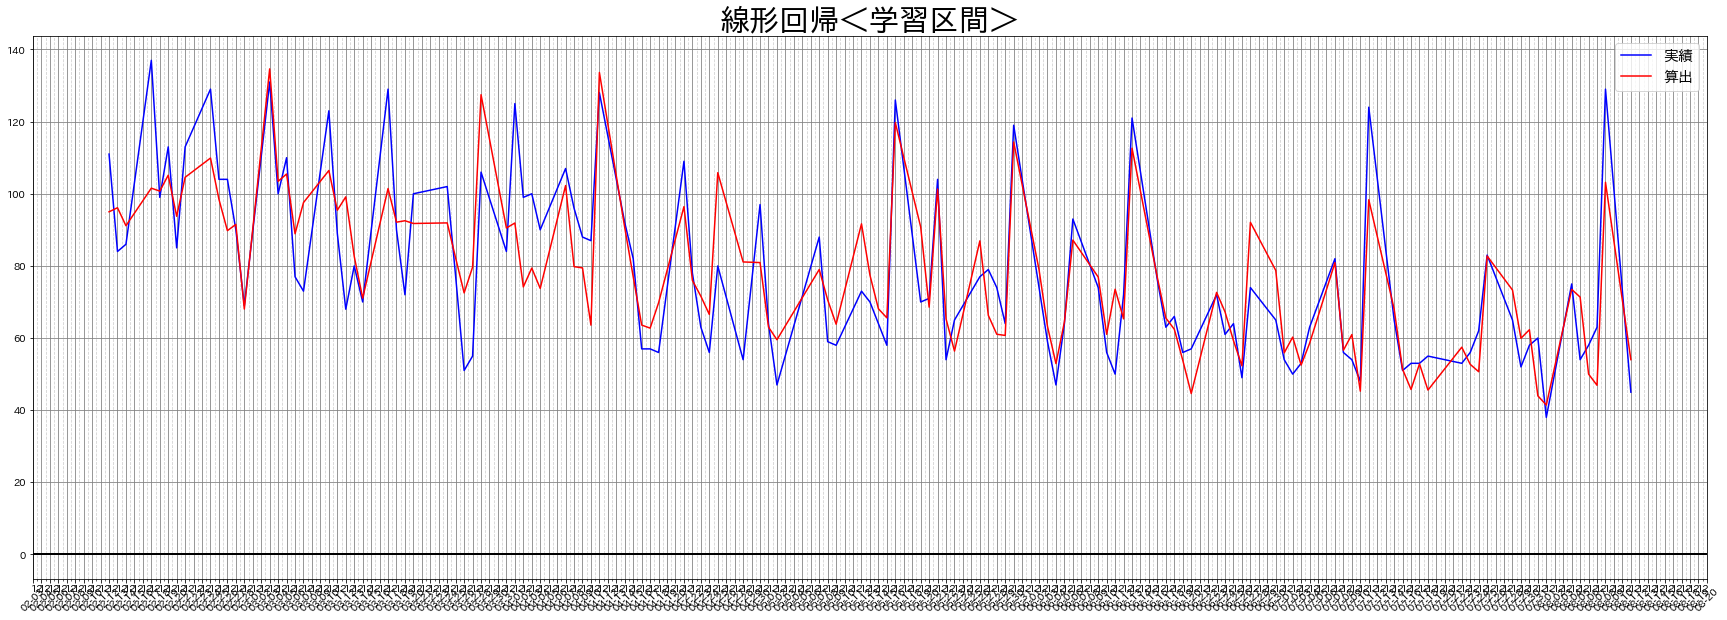

In [68]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_lr, color='red', label='算出')
ax.set_title('線形回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

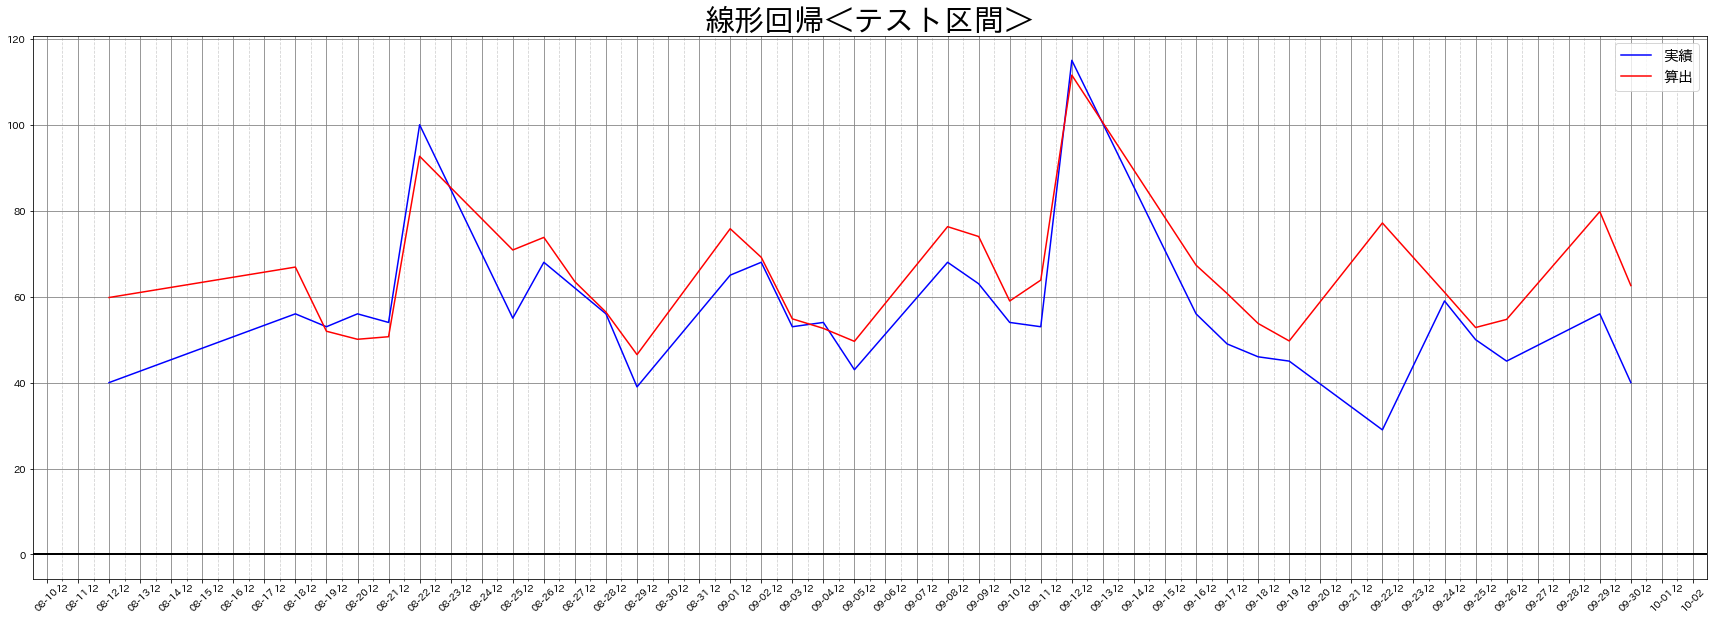

In [69]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_lr, color='red', label='算出')
ax.set_title('線形回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

RMSE

In [70]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [71]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_lr)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_lr)))

学習区間：12.617903065388374
テスト区間：13.093659560664848


### 後処理

In [72]:
train_data_merged["predict_y"] = y_pred_train_data_lr
val_data_merged["predict_y"] = y_pred_val_data_lr

In [73]:
predict_tr_val = pd.concat([train_data_merged, val_data_merged])

In [74]:
predict_tr_val.to_csv("result_tr_val_case2.csv")

## ランダムフォレスト回帰

In [75]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split, GridSearchCV

In [76]:
rg = RFR(n_jobs=-1, random_state=19)
rg.fit(X_train_data_scaled, y_train_data)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=19, verbose=0, warm_start=False)

In [77]:
y_pred_train_data_rg = rg.predict(X_train_data_scaled)
y_pred_val_data_rg = rg.predict(X_val_data_scaled)

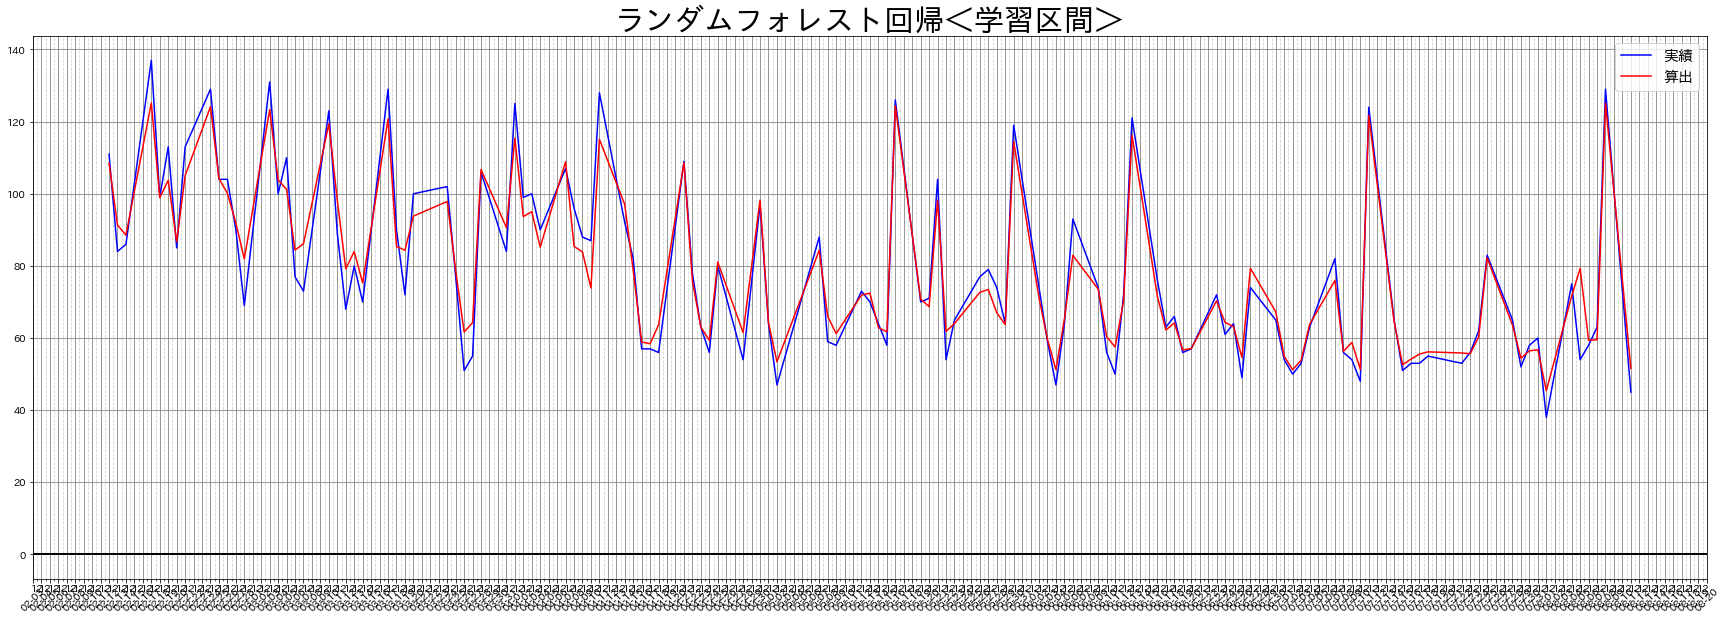

In [78]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

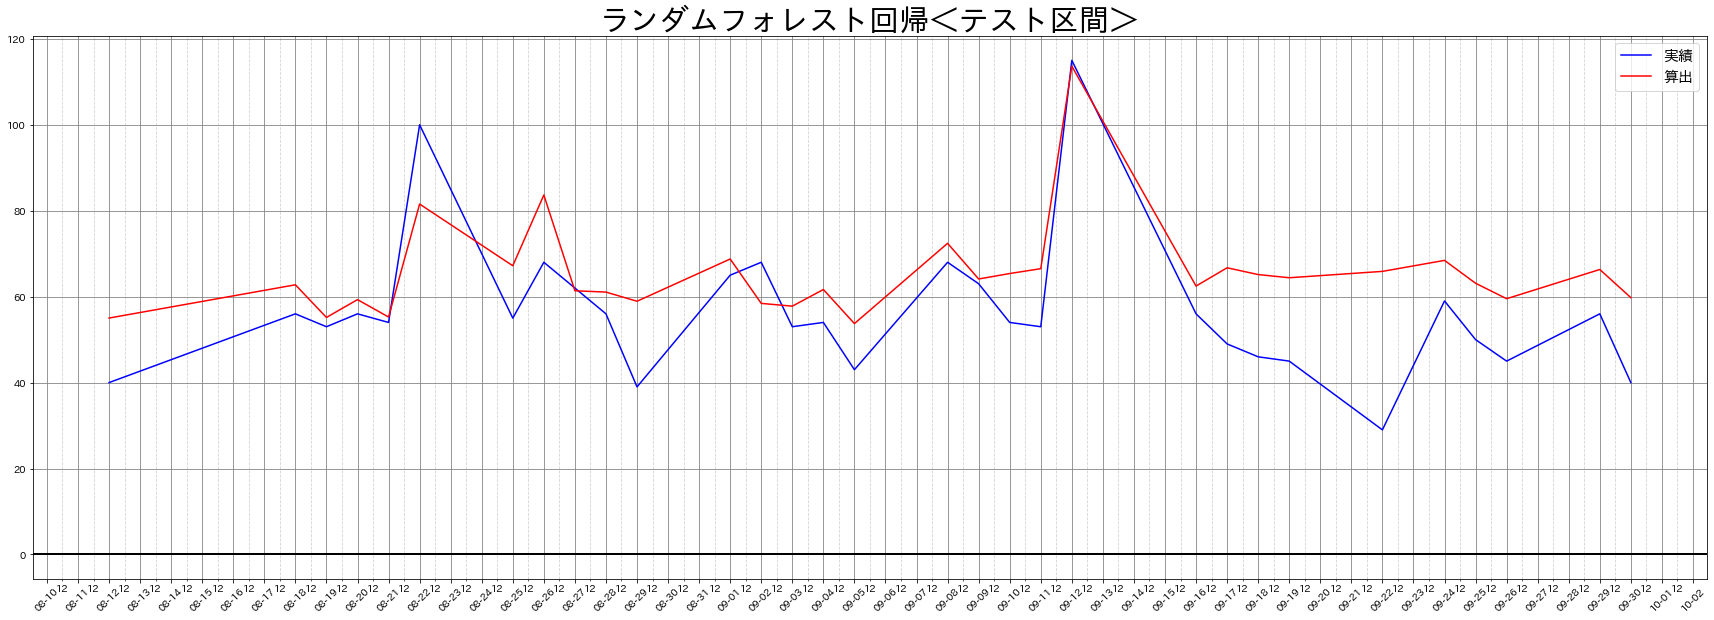

In [79]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [80]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_rg)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_rg)))

学習区間：5.8029484302267385
テスト区間：13.333323884405253


### ハイパーパラメータチューニング

パラメータについて  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [81]:
search_params = {
    'n_estimators'      : [5, 30, 100, 300], # 木の数
    'random_state'      : [19],
    'min_samples_split' : [2, 10, 30],
    # 'max_depth'         : [None, 1, 2, 3, 30, 100] # Noneが一番いいのにNoneにならない・・・
}
 
gs_rg = GridSearchCV(
    RFR(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=True
)
 
gs_rg.fit(X_train_data_scaled, y_train_data)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [82]:
print(gs_rg.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=19, verbose=0, warm_start=False)


In [83]:
y_pred_train_data_gs_rg = gs_rg.predict(X_train_data_scaled)
y_pred_val_data_gs_rg = gs_rg.predict(X_val_data_scaled)

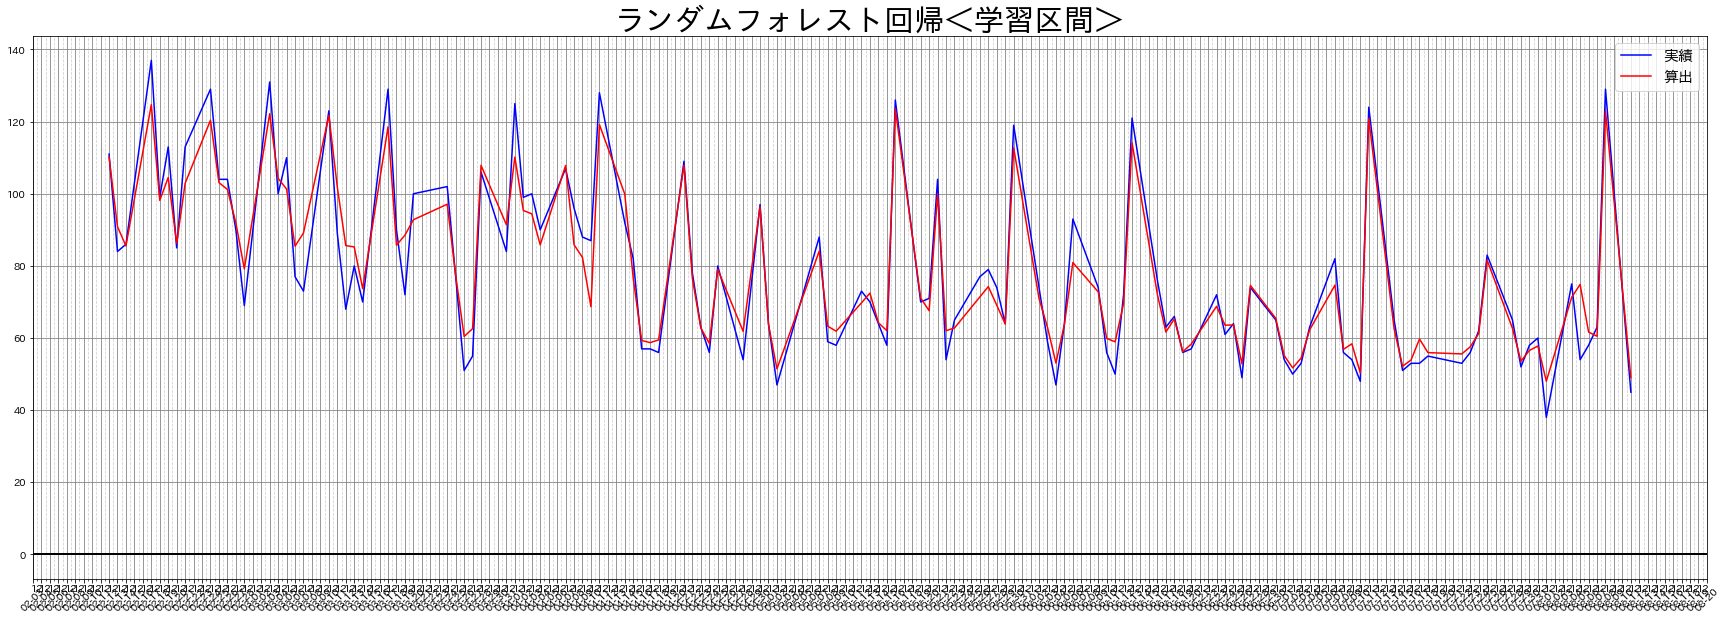

In [84]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_gs_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

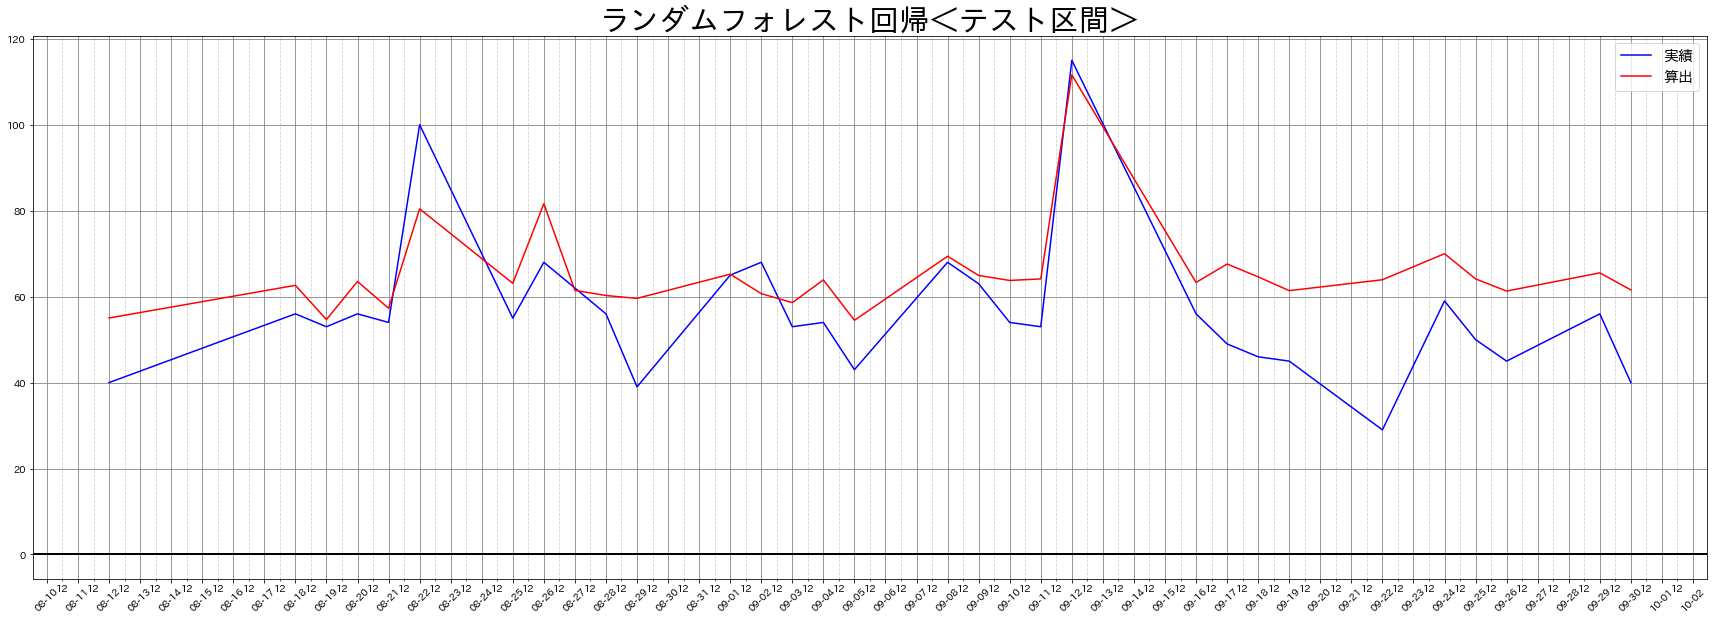

In [85]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_gs_rg, color='red', label='算出')
ax.set_title('ランダムフォレスト回帰＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [86]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_gs_rg)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_gs_rg)))

学習区間：6.234496182718356
テスト区間：13.132227997806767


## サポートベクター回帰（SVR）

In [87]:
from sklearn import svm

In [88]:
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [10**i for i in range(-4,3)], 'C': [10**i for i in range(-3, 4)]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

gs_svr = GridSearchCV(svm.SVR(), tuned_parameters, cv=3, scoring="neg_mean_squared_error")
gs_svr.fit(X_train_data_scaled, y_train_data)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [89]:
print(gs_svr.best_estimator_)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [90]:
y_pred_train_data_gs_svr = gs_svr.predict(X_train_data_scaled)
y_pred_val_data_gs_svr = gs_svr.predict(X_val_data_scaled)

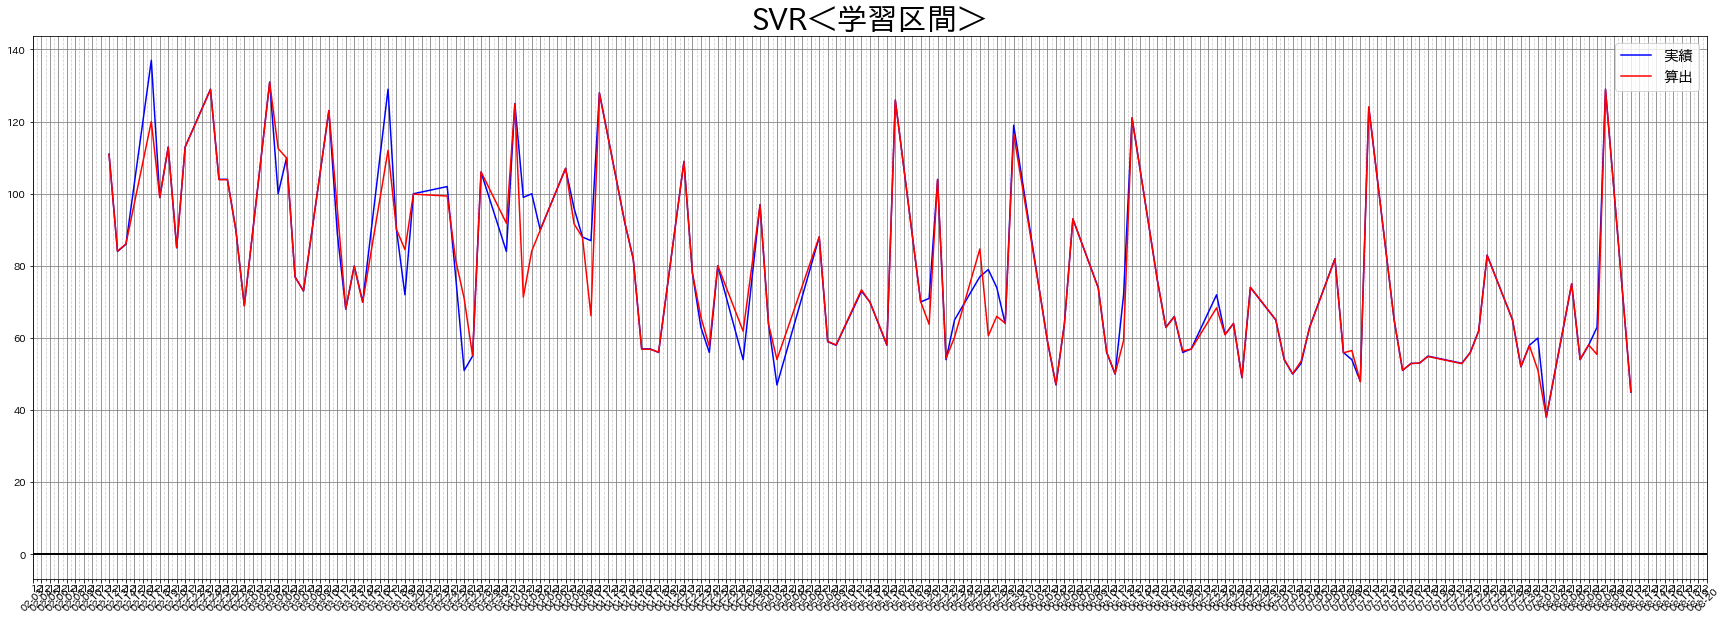

In [91]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_train_data.index, y_train_data, color='blue', label='実績')
ax.plot(X_train_data.index, y_pred_train_data_gs_svr, color='red', label='算出')
ax.set_title('SVR＜学習区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

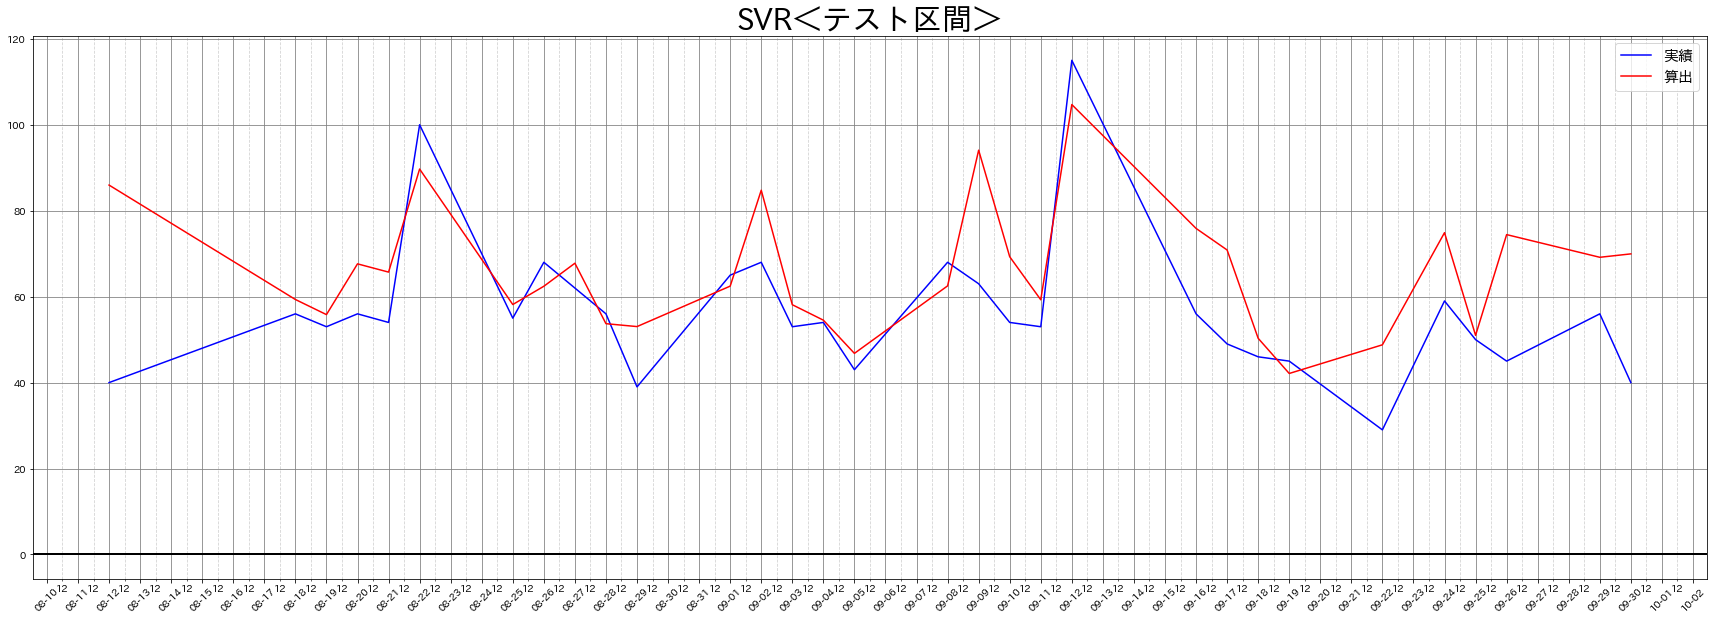

In [92]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(X_val_data.index, y_val_data, color='blue', label='実績')
ax.plot(X_val_data.index, y_pred_val_data_gs_svr, color='red', label='算出')
ax.set_title('SVR＜テスト区間＞', fontsize=30)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12), tz=None))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)

ax.grid(which='major', axis='both', color='grey')
ax.grid(which='minor', axis='x', linestyle='--', color='lightgrey')

ax.axhline(linewidth=2, color='black')

ax.legend(loc='upper right', fontsize=15)

### RMSE

In [93]:
print("学習区間：{}".format(rmse(y_train_data, y_pred_train_data_gs_svr)))
print("テスト区間：{}".format(rmse(y_val_data, y_pred_val_data_gs_svr)))

学習区間：5.590236721634007
テスト区間：16.037884612014054


## プロファイルレポート出力

※グラフの表示が変わってしまうので、最後にやる。

In [94]:
# pdp.ProfileReport(train_data_merged, check_correlation=False).to_file(outputfile="ProfileReport_train_data_merged.html")